# Simulation 6

**Mengqi Liu**

**Aug 13， 2023**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

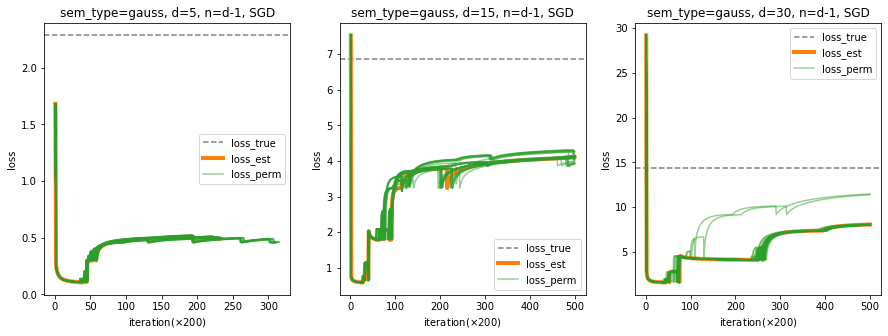

In [21]:
semtypes = ["gauss"]
ds = [5,15, 30]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
colormap = plt.cm.tab10
loss_f = ["loss_true", "loss_est"]
#losses = ["loss_est_2", "loss_l1_2", "obj_aug_", "obj_dual_2"]
#losses = ["loss_est_t", "loss_l1_t", "obj_aug_t", "obj_dual_t"]
#losses = ["h", "h_2", "h_t"]
for i, sem_type in enumerate(semtypes):
    for j, d in enumerate(ds):
        result = pd.read_csv("./results_loss/result_"+str(5001)+"_"+sem_type+"_"+str(d)+".csv")
       
        ax = axs[j]
        ax.axhline(y=result.iloc[0, 0], color='grey', linestyle='--', label=loss_f[0])
        ax.plot(np.arange(500)+1, result.iloc[1,:], marker='', label=loss_f[1], color=colormap(1), lw=4)
        for p in range(30):
            if p == 0:
                ax.plot(np.arange(500)+1, result.iloc[p+2,:], marker='', alpha=0.5, color=colormap(2), label="loss_perm")
            else:
                ax.plot(np.arange(500)+1, result.iloc[p+2,:], marker='', alpha=0.5, color=colormap(2))
        ax.set_xlabel(r'iteration($\times$200)')
        ax.set_ylabel("loss")
        ax.set_title(f'sem_type={sem_type}, d={ds[j]}, n=d-1, SGD')
        ax.legend()
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.savefig("./results_loss/loss_sgd_perm.png")
plt.show()

1. Method: SGD, Adam, ...
2. $2*d*d$ w -> d*d w
3. constraint w/ or w/o grad
4. learning rate 1, 0.1, 0.05, 0.03, 0.01, 0.001

In [6]:
def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()

In [13]:
is_dag(np.tril(np.ones([10, 10]), k=-1))

True

In [14]:
np.tril(np.ones([10, 10]), k=-1)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]])

In [3]:
import utils
import torch
import estimate
import numpy as np
import igraph as ig

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    true positive = predicted association exists in condition in correct direction
    reverse = predicted association exists in condition in opposite direction
    false positive = predicted association does not exist in condition

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        fdr: (reverse + false positive) / prediction positive
        tpr: (true positive) / condition positive
        fpr: (reverse + false positive) / condition negative
        shd: undirected extra + undirected missing + reverse
        nnz: prediction positive
    """
    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        #if not is_dag(B_est):
        #    raise ValueError('B_est should be a DAG')
    d = B_true.shape[0]
    # linear index of nonzeros
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])
    # true pos
    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    # treat undirected edge favorably
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])
    # false pos
    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])
    # reverse
    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)
    # compute ratio
    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)
    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)
    # structural hamming distance
    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)
    return {'fdr': fdr, 'tpr': tpr, 'fpr': fpr, 'shd': shd, 'nnz': pred_size}


In [18]:
w_true = np.load('w_true.npy')
w_est = np.load('w_est.npy')

In [19]:
w_est[np.abs(w_est) < 0.3] = 0

In [20]:
count_accuracy(w_est!=0, w_true!=0)

{'fdr': 0.20689655172413793,
 'tpr': 0.2072072072072072,
 'fpr': 0.018518518518518517,
 'shd': 94,
 'nnz': 29}

In [10]:
w_est

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.49835604,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.8136295 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.829911  ,  0.        ,  0.        ,  0.        ,
         0.        , -0.5152156 ,  0.        ,  0.8817333 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.52652085,  0.        ,
         0.        ,  1.4916869 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , 

In [3]:
utils.set_random_seed(1)
B_true = utils.simulate_dag(10, 10, "ER", device)
W_true = utils.simulate_parameter(B_true)
X = utils.simulate_linear_sem(W_true, 9, "gauss")

In [1]:
W_est = [[ 1.31631197e-04 -2.14424042e-04  3.32181118e-02  3.72303456e-01
   8.94480690e-05  1.91039534e-03  1.84886586e-02 -1.53818895e-04
   5.50714030e-04 -1.88235082e-02]
 [ 4.03238267e-01  6.95475203e-04 -1.93483222e+00  1.65096653e+00
  -5.07586636e-04  4.05574171e-03  1.05963849e-01  2.16507360e-01
   9.04781759e-01  1.59648240e-01]
 [ 2.26211831e-01 -3.81514197e-04  4.37342678e-04  6.69701695e-01
   4.11911344e-04 -1.65088556e-03  2.81843692e-02  7.66151696e-02
   4.38533932e-01  4.91767703e-03]
 [ 4.56478866e-03  1.72201489e-05 -6.14123346e-05  5.49298493e-05
   1.17491090e-05  4.12048430e-05 -4.75859502e-04 -5.25628820e-05
  -1.17373704e-04  5.72012250e-05]
 [-1.59863025e-01 -1.18208289e+00 -5.62243581e-01  1.84112930e+00
   4.07535204e-04 -1.88163435e-03 -1.08656093e-01  1.27042010e-01
   8.54814827e-01 -1.51536882e-01]
 [ 1.31280139e-01  1.69840351e-01 -2.46688649e-01  1.20887637e+00
  -4.89400506e-01  1.87070618e-04 -2.18180999e-01 -1.89857278e-02
   1.00977194e+00  2.80563696e-03]
 [ 2.58939136e-02  2.52766367e-02  3.07130069e-02 -6.73542976e-01
  -1.01106964e-01 -1.00319069e-02  2.54528248e-04 -3.36810714e-03
   8.24555337e-01 -3.40276301e-01]
 [-8.27535272e-01 -5.41861728e-03  1.36235327e-01 -6.69254303e-01
   3.89717543e-03 -2.63975561e-01 -4.08989012e-01  1.45460464e-04
   1.26454008e+00  3.38197470e-01]
 [ 5.72331667e-01 -1.10183908e-04  3.53922369e-03 -6.74431741e-01
   5.75836821e-05  2.98407995e-05  3.21536791e-04  3.41510822e-05
   1.23879479e-04 -2.68045627e-03]
 [-3.00297052e-01  4.51097935e-02  1.67588890e-01  6.46240473e-01
  -8.73661041e-02  7.42630437e-02 -1.48369046e-02  1.41544770e-02
  -1.54721051e-01  2.02516268e-04]]

SyntaxError: invalid syntax (1778582029.py, line 1)

learning rate = 0.03/ 0.01 

In [4]:
a = estimate.notears_linear(X, W_true=W_true, lambda1=0, loss_type="l2")

/Users/aurora/Desktop/My_files/Uchi/summer/Notears_loss/estimate.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32, device=device)


Iteration 10: Loss = 3.1068549156188965, h = 0.6904525756835938, rho = 1.0, alpha = 0.0
0.16828560829162598
Iteration 20: Loss = 2.156264066696167, h = 0.8192844390869141, rho = 1.0, alpha = 0.0
0.059973955154418945
Iteration 30: Loss = 1.757556438446045, h = 0.8823795318603516, rho = 1.0, alpha = 0.0
0.028423428535461426
Iteration 40: Loss = 1.5444560050964355, h = 0.9058246612548828, rho = 1.0, alpha = 0.0
0.01702892780303955
Iteration 50: Loss = 1.4076520204544067, h = 0.9038448333740234, rho = 1.0, alpha = 0.0
0.011742472648620605
Iteration 60: Loss = 1.3072597980499268, h = 0.8889608383178711, rho = 1.0, alpha = 0.0
0.008951783180236816
Iteration 70: Loss = 1.2277579307556152, h = 0.8701763153076172, rho = 1.0, alpha = 0.0
0.007224321365356445
Iteration 80: Loss = 1.1627061367034912, h = 0.8512783050537109, rho = 1.0, alpha = 0.0
0.0059735774993896484
Iteration 90: Loss = 1.1083736419677734, h = 0.8345346450805664, rho = 1.0, alpha = 0.0
0.005026578903198242
Iteration 100: Loss = 

In [5]:
3 + [1,2,3]

TypeError: unsupported operand type(s) for +: 'int' and 'list'

In [5]:
h_new = torch.tensor(float('inf'), dtype=torch.float, device=device)
h = torch.tensor(float('inf'), dtype=torch.float, device=device)

In [6]:
a

(nan,
 nan,
 nan,
 nan,
 223692176.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 4.760077953338623,
 4.760077953338623,
 4.760077953338623,
 nan,
 0.0,
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32))